In [1]:
import sys, os, argparse
import torch
import numpy as np
import pandas as pd #use for memory efficiency but need to redefine each clustering function

import matplotlib.pyplot as plt

import pickle
from sklearn.utils.extmath import randomized_svd, make_nonnegative
from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema
from ete3 import Tree

class Counter:
    def __init__(self,init_val=-1):
        self.count = init_val

    def get_new_id(self):
        self.count += 1
        return self.count
        
def SpectralBiCoClustering(data,random_state=None,n_components=2):
    """
    extract both fiedler vector from "data"
    """
    data[data <= 0] = 1e-10
    row_diag = np.asarray(1.0 / np.sqrt(data.sum(axis=1))).squeeze()
    col_diag = np.asarray(1.0 / np.sqrt(data.sum(axis=0))).squeeze()
    row_diag = np.where(np.isnan(row_diag), 0, row_diag)
    col_diag = np.where(np.isnan(col_diag), 0, col_diag)
    
    an = row_diag[:, np.newaxis] * data * col_diag
    an = np.where(np.isnan(an), 1, an)
    an = np.where(np.isinf(an), 1, an)
    
    U, S, Vt = randomized_svd(an, 
                              n_components=n_components,
                              n_iter=10,
                              random_state=random_state)

    Fiedler_U = U[:,1]
    Fiedler_V = Vt[1]
    
    return Fiedler_U, Fiedler_V,S[1],col_diag



def _RecClusterDataToTree(df,ids,seq_ids,treenode,counter,distsum,th_mode="simple",K=10,mode='valley',n_min=64):
    """
    Recursively build a clustering dendrogram
    """
    
    data = np.array(df.iloc[ids])
    U,V,S,cd = SpectralBiCoClustering(data)
    

    th = None
    if th_mode == "0":
        th = 0
    if th_mode == "kde" and len(data) >= n_min:
        const = int(K/ (U[:, np.newaxis].max() - U[:, np.newaxis].min()))
        X = U[:, np.newaxis]*const #scale of data seems to be important for kde (bandwidth)
        X_eval = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis] 
        kde = KernelDensity(kernel="gaussian", bandwidth="scott").fit(X)
        log_dens = kde.score_samples(X_eval)
        
        try:
            if mode == "min": #smallest local min of density
                argm = argrelextrema(log_dens,np.less)[0]

                th_id = argm[log_dens[argm].argmin()]
                th = (X_eval/const)[th_id][0]

            if mode == "valley": #search for 2 high density peaks and the deepest valley between them
                loc_min = argrelextrema(log_dens,np.less)[0]
                loc_max = argrelextrema(log_dens,np.greater)[0]
                
                local_extrema = [loc_max[0]]
                for i in range(len(loc_min)):
                    local_extrema.append(loc_min[i])
                    local_extrema.append(loc_max[i+1])
                
                left_dist = [] #highest peak at the left of the valley
                curr_l_max = log_dens[local_extrema][0]
                for i in log_dens[local_extrema]:
                    if i > curr_l_max:
                        curr_l_max = i
                    left_dist.append(curr_l_max-i)
                
                right_dist = [] #highest peak at the right of the valley
                curr_r_max = log_dens[local_extrema][-1]
                for i in log_dens[local_extrema][::-1]:
                    if i > curr_r_max:
                        curr_r_max = i
                    right_dist.append(curr_r_max-i)
                
                dist_prod = np.array(left_dist)*np.array(right_dist[::-1])
                
                th_id = loc_min[(dist_prod.argmax()-1)//2]
                th = (X_eval/const)[th_id][0]
        except:
            pass
        
    if th == None: #search for largest gap between datapoints in the projection
        u_cpy = U.copy()
        u_cpy.sort()
        idx = np.argmax(u_cpy[1:]-u_cpy[:-1])
        th = (u_cpy[idx+1]+u_cpy[idx])/2
    
    neg_idx = np.where(U < th)[0]
    pos_idx = np.where(U >= th)[0]
    
    assert (len(neg_idx) > 0)
    assert (len(pos_idx) > 0)
    
    neg_distsum = (1-data[neg_idx]).sum()
    pos_distsum = (1-data[pos_idx]).sum()
    del data
    
    neg_seq_ids = [seq_id for e,seq_id in enumerate(seq_ids) if (e in neg_idx)]
    pos_seq_ids = [seq_id for e,seq_id in enumerate(seq_ids) if (e in pos_idx)]

    treenode.add_feature("V",V)
    treenode.add_feature("U",U)
    treenode.add_feature("th",th)
    treenode.add_feature("S",S)
    treenode.add_feature("cd",cd)

    if (len(neg_idx) > 1): 
        name = "I"+str(counter.get_new_id())
        neg_node = treenode.add_child(name=name)
        #neg_distsum = (1-data[neg_idx]).sum()
        neg_node.dist = distsum - neg_distsum 
        _RecClusterDataToTree(df,ids[neg_idx],neg_seq_ids,neg_node,counter,neg_distsum,th_mode=th_mode,K=K)

    if (len(pos_idx) > 1):
        name = "I"+str(counter.get_new_id())
        pos_node = treenode.add_child(name=name)
        #pos_distsum = (1-data[pos_idx]).sum()
        pos_node.dist = distsum - pos_distsum
        _RecClusterDataToTree(df,ids[pos_idx],pos_seq_ids,pos_node,counter,pos_distsum,th_mode=th_mode,K=K)

    if (len(neg_idx) == 1):
        neg_node = treenode.add_child(name=neg_seq_ids[0])
        #neg_distsum = (1-data[neg_idx]).sum()
        neg_node.dist = distsum

        
    if (len(pos_idx) == 1):
        pos_node = treenode.add_child(name=pos_seq_ids[0])
        #pos_distsum = (1-data[pos_idx]).sum()
        pos_node.dist = distsum


def ClusterDataToTree(df,seq_ids,fname = "",pickle_name = "",th_mode="simple",mode="valley",K=10,n_min=64):
    """
    Build clustering dendrogram and save it in extended newick format and pickle format
    """
    data = np.array(df)
    counter = Counter()
    root = Tree()
    distsum = (1-data).sum()
    len_data = len(data)
    del data
    ids = np.array(list(range(len_data)))
    _RecClusterDataToTree(df,ids,seq_ids,root,counter,distsum,th_mode=th_mode,K=K,mode=mode,n_min=n_min)
    if fname != "":
        root.write(format=1,outfile=fname)
    if pickle_name != "":
        with open(pickle_name, 'wb') as handle:
            pickle.dump(root, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return root


def _RecClusterDataToTreeZha(df,ids,feat_ids,seq_ids,treenode,counter,distsum,th_mode="simple",K=10,prog_bar=None,mode='valley',n_min=64):
    """
    Recursively build a clustering dendrogram
    """
    data = np.array(df[feat_ids].iloc[ids])
    U,V,S,cd = SpectralBiCoClustering(data)
    u_cpy = U.copy()

    th = 0
    
    neg_idx = np.where(U < th)[0]
    pos_idx = np.where(U >= th)[0]
    
    neg_feat_idx = np.where(V < th)[0]
    pos_feat_idx = np.where(V >= th)[0]
    
    if (len(neg_idx) == 0):
        neg_idx = U.argsort()[[0]]
        pos_idx = U.argsort()[1:]
    
    if (len(pos_idx) == 0):
        neg_idx = U.argsort()[:-1]
        pos_idx = U.argsort()[[-1]]
    
    if (len(neg_feat_idx) == 0):
        neg_feat_idx = V.argsort()[[0]]
        pos_feat_idx = V.argsort()[1:]
    
    if (len(pos_feat_idx) == 0):
        neg_feat_idx = V.argsort()[:-1]
        pos_feat_idx = V.argsort()[[-1]]
        
    assert (len(neg_idx) > 0)
    assert (len(pos_idx) > 0)

    neg_seq_ids = [seq_id for e,seq_id in enumerate(seq_ids) if (e in neg_idx)]
    pos_seq_ids = [seq_id for e,seq_id in enumerate(seq_ids) if (e in pos_idx)]

    treenode.add_feature("V",V)
    treenode.add_feature("U",U)
    treenode.add_feature("th",th)
    treenode.add_feature("S",S)
    treenode.add_feature("cd",cd)
    
    dist_cut = (1-data[neg_idx][:,pos_feat_idx]).sum() + (1-data[pos_idx][:,neg_feat_idx]).sum()
    
    neg_distsum = (1-data[neg_idx][:,neg_feat_idx]).sum() + dist_cut/2
    pos_distsum = (1-data[pos_idx][:,pos_feat_idx]).sum() + dist_cut/2
    

    
    if (len(neg_idx) > 1) and (len(neg_feat_idx) > 1):
        name = "I"+str(counter.get_new_id())
        neg_node = treenode.add_child(name=name)
        #neg_distsum = (1-data[neg_idx][:,neg_feat_idx]).sum() + dist_cut/2
        neg_node.dist = distsum - neg_distsum #- dist_cut/2
        _RecClusterDataToTreeZha(df,ids[neg_idx],feat_ids[neg_feat_idx],neg_seq_ids,neg_node,counter,neg_distsum,th_mode=th_mode,K=K,prog_bar=prog_bar)

    if (len(pos_idx) > 1) and (len(pos_feat_idx) > 1):
        name = "I"+str(counter.get_new_id())
        pos_node = treenode.add_child(name=name)
        #pos_distsum = (1-data[pos_idx][:,pos_feat_idx]).sum() + dist_cut/2
        pos_node.dist = distsum - pos_distsum #- dist_cut/2
        _RecClusterDataToTreeZha(df,ids[pos_idx],feat_ids[pos_feat_idx],pos_seq_ids,pos_node,counter,pos_distsum,th_mode=th_mode,K=K,prog_bar=prog_bar)
    
    if (len(neg_feat_idx) == 1) and (len(neg_idx) > 1):
        name = "I"+str(counter.get_new_id())
        neg_node = treenode.add_child(name=name)
        #neg_distsum = (1-data[neg_idx]).sum() + dist_cut/2
        neg_node.dist = distsum - neg_distsum 
        for i in range(len(neg_seq_ids)):
            neg_leaf = neg_node.add_child(name=neg_seq_ids[i])
            #neg_distsum = (1-data[neg_idx[i]]).sum()
            neg_leaf.dist = neg_distsum

            
    if (len(pos_feat_idx) == 1) and (len(pos_idx) > 1):
        name = "I"+str(counter.get_new_id())
        pos_node = treenode.add_child(name=name)
        #pos_distsum = (1-data[pos_idx]).sum() + dist_cut/2
        pos_node.dist = distsum - pos_distsum 
        for i in range(len(pos_seq_ids)):
            pos_leaf = pos_node.add_child(name=pos_seq_ids[i])
            #pos_distsum = (1-data[pos_idx[i]]).sum()
            pos_leaf.dist = pos_distsum

            
    if (len(neg_feat_idx) >= 1) and (len(neg_idx) == 1):
        neg_node = treenode.add_child(name=neg_seq_ids[0])
        neg_distsum = (1-data[neg_idx]).sum()
        neg_node.dist = distsum

        
    if (len(pos_feat_idx) >= 1) and (len(pos_idx) == 1):
        pos_node = treenode.add_child(name=pos_seq_ids[0])
        pos_distsum = (1-data[pos_idx]).sum() 
        pos_node.dist = distsum 


def ClusterDataToTreeZha(df,seq_ids,fname = "",pickle_name = "",th_mode="simple",mode="valley",K=10,n_min=64):
    """
    Build clustering dendrogram and save it in extended newick format and pickle format
    """
    data = np.array(df)
    counter = Counter()
    root = Tree()
    distsum = (1-data).sum()
    len_data = len(data)
    len_features = len(data[0])
    del data
    ids = np.array(list(range(len_data)))
    feat_ids = np.array(list(range(len_features)))
    
    _RecClusterDataToTreeZha(df,ids,feat_ids,seq_ids,root,counter,distsum,th_mode=th_mode,K=K,mode=mode,n_min=n_min)
    if fname != "":
        root.write(format=1,outfile=fname)
    if pickle_name != "":
        with open(pickle_name, 'wb') as handle:
            pickle.dump(root, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return root
        
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score, classification_report

from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.feature_extraction.text import TfidfTransformer

In [2]:
newsgroups_vectorized = fetch_20newsgroups_vectorized(subset='all')
tfidf = TfidfTransformer()
tfidf_data = tfidf.fit_transform(newsgroups_vectorized.data)
data = tfidf_data.toarray().astype(np.float32)
sum_col = data.sum(0)

seq_ids = []

cpt_dict = {i:0 for i in range(20)}

for tgt in newsgroups_vectorized.target:
    cpt = cpt_dict[tgt]
    seq_id = str(tgt)+"_"+str(cpt)
    cpt_dict[tgt] += 1
    seq_ids.append(seq_id)

x = data[:,np.where(sum_col > 2)].reshape(18846,-1)

In [3]:
del newsgroups_vectorized
del tfidf
del tfidf_data
del data
del sum_col

In [4]:
import time
df = pd.DataFrame(x)


sys.setrecursionlimit(10000)
save_pkl = False
pkl_name= "trees/20newsgroups.pkl" if save_pkl else ""
tree = ClusterDataToTree(df,seq_ids, fname = "trees/20newsgroups.tree",pickle_name=pkl_name, th_mode="kde",mode="valley",K=10,n_min=1)

In [8]:
tree_Zha = ClusterDataToTreeZha(df,seq_ids, fname = "trees/20newsgroups_Zha.tree",pickle_name="")

In [13]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import to_tree
from scipy.cluster.hierarchy import ClusterNode

from typing import List

def _scipy_tree_to_newick_list(node: ClusterNode, newick: List[str], parentdist: float, leaf_names: List[str],counter: Counter) -> List[str]:
    """Construct Newick tree from SciPy hierarchical clustering ClusterNode

    This is a recursive function to help build a Newick output string from a scipy.cluster.hierarchy.to_tree input with
    user specified leaf node names.

    Notes:
        This function is meant to be used with `to_newick`

    Args:
        node (scipy.cluster.hierarchy.ClusterNode): Root node is output of scipy.cluster.hierarchy.to_tree from hierarchical clustering linkage matrix
        parentdist (float): Distance of parent node of `node`
        newick (list of string): Newick string output accumulator list which needs to be reversed and concatenated (i.e. `''.join(newick)`) for final output
        leaf_names (list of string): Leaf node names

    Returns:
        (list of string): Returns `newick` list of Newick output strings
    """
    if node.is_leaf():
        return newick + [f'{leaf_names[node.id]}:{parentdist - node.dist}']

    if len(newick) > 0:
        id = "I"+str(counter.get_new_id())
        newick.append(")"+id+":"+f'{parentdist - node.dist}')
    else:
        id = "I"+str(counter.get_new_id())
        newick.append(')'+id+';')

    newick = _scipy_tree_to_newick_list(node.get_left(), newick, node.dist, leaf_names,counter)
    newick.append(',')
    newick = _scipy_tree_to_newick_list(node.get_right(), newick, node.dist, leaf_names,counter)
    newick.append('(')
    return newick


def to_newick(tree: ClusterNode, leaf_names: List[str]) -> str:
    """Newick tree output string from SciPy hierarchical clustering tree

    Convert a SciPy ClusterNode tree to a Newick format string.
    Use scipy.cluster.hierarchy.to_tree on a hierarchical clustering linkage matrix to create the root ClusterNode for the `tree` input of this function.

    Args:
        tree (scipy.cluster.hierarchy.ClusterNode): Output of scipy.cluster.hierarchy.to_tree from hierarchical clustering linkage matrix
        leaf_names (list of string): Leaf node names

    Returns:
        (string): Newick output string
    """
    counter = Counter()
    newick_list = _scipy_tree_to_newick_list(tree, [], tree.dist, leaf_names,counter)
    return ''.join(newick_list[::-1])

def build_tree(repr_space,labels,fname):
    """
    Hierarchical clustering of the sequence in the representation space, reprensented as a Newick tree
    """
    Z = linkage(repr_space,"ward")
    T = to_tree(Z, rd = "False")[0]
    #return T
    print(to_newick(T,labels),file=open(fname,"w"))
    

build_tree(x,seq_ids,os.path.join("trees/20newsgroups_Ward.tree"))

In [4]:
def KL(a, b):
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

def get_dist_memo(memo,tree):
    if tree.name not in memo:
        lab_count = np.zeros(7)
        for i in tree.get_leaf_names():
            _, idx = leaf_name_to_high_lab(i)
            lab_count[idx] += 1
        memo[tree.name] = lab_count
    return memo[tree.name]

memo = dict()

th = 20
def get_pred(leaf,true,memo=memo,th=th):
    ancestors = leaf.get_ancestors()
    for ances in ancestors:
        if len(ances) < th:
            continue
        break
    dist = get_dist_memo(memo,ances).copy()
    dist[true]-=1
    pred = dist.argmax()
    return pred

newsgroups_vectorized = fetch_20newsgroups_vectorized(subset='all')

l_high_lab = []
for i in newsgroups_vectorized.target_names:
    if i.split(".")[0] not in l_high_lab:
        l_high_lab.append(i.split(".")[0])
l_high_lab

def leaf_name_to_high_lab(leaf_name):
    lab = int(leaf_name.split("_")[0])
    lab_name = newsgroups_vectorized.target_names[lab]
    high_lab = lab_name.split(".")[0]
    idx = l_high_lab.index(high_lab)
    return high_lab, idx

l_high = ['alt', 'comp', 'misc', 'rec', 'sci', 'soc', 'talk']
l_col_high = ['#66c2a5', '#fc8d62', '#8da0cb', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']

In [29]:
t = Tree("trees/20newsgroups.tree",format=1)
memo = dict()

mcc=0.7259320196984084
accuracy: 0.7787328876154092
              precision    recall  f1-score   support

         alt       0.75      0.67      0.71       799
        comp       0.74      0.91      0.82      4891
        misc       0.83      0.30      0.44       975
         rec       0.83      0.87      0.85      3979
         sci       0.79      0.64      0.71      3952
         soc       0.66      0.74      0.70       997
        talk       0.81      0.82      0.81      3253

    accuracy                           0.78     18846
   macro avg       0.77      0.71      0.72     18846
weighted avg       0.78      0.78      0.77     18846



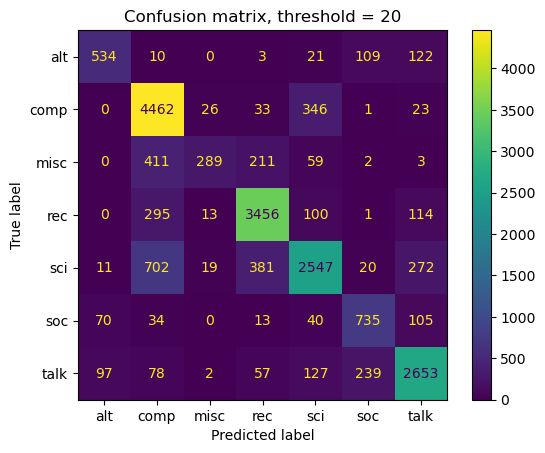

In [30]:
th = 20

conf_mat = np.zeros((7,7))
y_true = []
y_pred = []
for leaf in t:
    high_lab, true = leaf_name_to_high_lab(leaf.name)
    pred = get_pred(leaf,true,th=th)
    conf_mat[true,pred] += 1
    y_true.append(true)
    y_pred.append(pred)
    

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=l_high_lab)
disp.plot(values_format = '.0f')
plt.title("Confusion matrix, threshold = "+str(th))
mcc = matthews_corrcoef(y_true,y_pred)
print(f"{mcc=}")
print(f'accuracy: {accuracy_score(y_true, y_pred)}')
print(classification_report(y_true, y_pred, target_names=l_high_lab))

with open('iTOL/20news/itol_20news_strip_Bottom-Up_pred_SCUT.txt','w') as f:
    f.write("DATASET_COLORSTRIP\n")
    f.write("SEPARATOR TAB\n")
    f.write("DATASET_LABEL\tnewsgroup_pred_bottom-up\n")
    f.write("COLOR\t#ff0000\n")
    f.write("LEGEND_TITLE\tNewsgroups_pred_bottom-up\n")
    f.write("LEGEND_SCALE\t1\n")
    f.write("LEGEND_SHAPES"+"\t1"*len(l_high)+"\n")
    f.write("LEGEND_COLORS\t"+"\t".join(l_col_high)+"\n")
    f.write("LEGEND_LABELS\t"+"\t".join(l_high)+"\n")
    
    f.write("DATA\n")
    
    for leaf in t:
        high_lab, true = leaf_name_to_high_lab(leaf.name)
        pred = get_pred(leaf,true,th=th)
        seq_id = leaf.name
        col = l_col_high[pred]
        label = l_high[pred]
        f.write(seq_id+"\t"+col+"\t"+label+"\n")

mcc=0.5600913883645664
accuracy: 0.6470338533375782
              precision    recall  f1-score   support

         alt       0.61      0.63      0.62       799
        comp       0.65      0.71      0.68      4891
        misc       0.41      0.22      0.29       975
         rec       0.66      0.73      0.69      3979
         sci       0.64      0.58      0.61      3952
         soc       0.61      0.52      0.56       997
        talk       0.70      0.69      0.69      3253

    accuracy                           0.65     18846
   macro avg       0.61      0.58      0.59     18846
weighted avg       0.64      0.65      0.64     18846



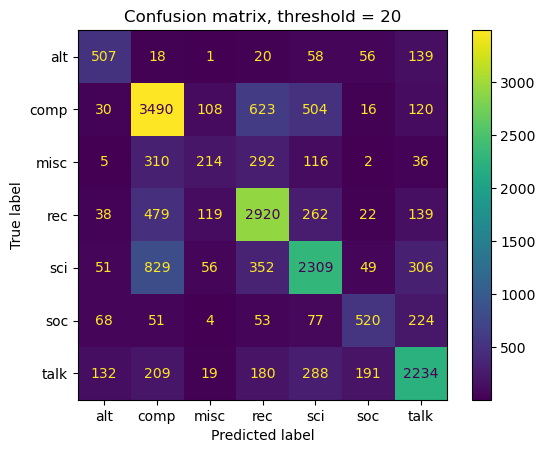

In [39]:
t2 = Tree("trees/20newsgroups_Zha.tree",format=1)
memo2 = dict()

th = 20

conf_mat = np.zeros((7,7))
y_true = []
y_pred = []
for leaf in t2:
    high_lab, true = leaf_name_to_high_lab(leaf.name)
    pred = get_pred(leaf,true,memo=memo2,th=th)
    conf_mat[true,pred] += 1
    y_true.append(true)
    y_pred.append(pred)
    

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=l_high_lab)
disp.plot(values_format = '.0f')
plt.title("Confusion matrix, threshold = "+str(th))
acc = conf_mat.diagonal().sum()/conf_mat.sum()
mcc = matthews_corrcoef(y_true,y_pred)
print(f"{mcc=}")
print(f'accuracy: {accuracy_score(y_true, y_pred)}')
print(classification_report(y_true, y_pred, target_names=l_high_lab))

with open('iTOL/20news/itol_20news_strip_Bottom-Up_pred_Zha.txt','w') as f:
    f.write("DATASET_COLORSTRIP\n")
    f.write("SEPARATOR TAB\n")
    f.write("DATASET_LABEL\tnewsgroup_pred_bottom-up\n")
    f.write("COLOR\t#ff0000\n")
    f.write("LEGEND_TITLE\tNewsgroups_pred_bottom-up\n")
    f.write("LEGEND_SCALE\t1\n")
    f.write("LEGEND_SHAPES"+"\t1"*len(l_high)+"\n")
    f.write("LEGEND_COLORS\t"+"\t".join(l_col_high)+"\n")
    f.write("LEGEND_LABELS\t"+"\t".join(l_high)+"\n")
    
    f.write("DATA\n")

    for leaf in t2:
        high_lab, true = leaf_name_to_high_lab(leaf.name)
        pred = get_pred(leaf,true,th=th,memo=memo2)
        seq_id = leaf.name
        col = l_col_high[pred]
        label = l_high[pred]
        f.write(seq_id+"\t"+col+"\t"+label+"\n")

mcc=0.5990481330164402
accuracy: 0.6777565531147193
              precision    recall  f1-score   support

         alt       0.74      0.56      0.64       799
        comp       0.62      0.80      0.70      4891
        misc       0.46      0.33      0.38       975
         rec       0.71      0.71      0.71      3979
         sci       0.71      0.61      0.65      3952
         soc       0.72      0.67      0.69       997
        talk       0.74      0.69      0.72      3253

    accuracy                           0.68     18846
   macro avg       0.67      0.62      0.64     18846
weighted avg       0.68      0.68      0.67     18846



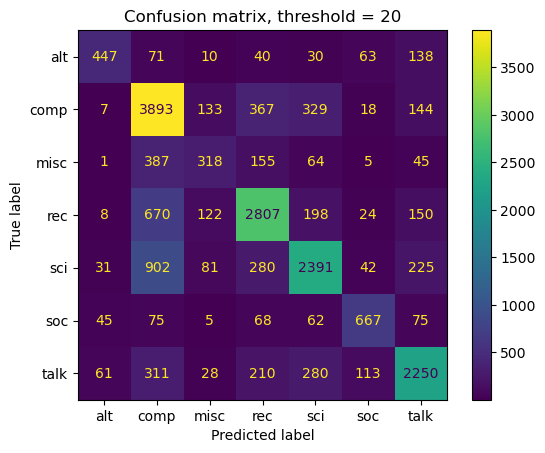

In [41]:
t = Tree("trees/20newsgroups_Ward.tree",format=1)
memo = dict()

th = 20

conf_mat = np.zeros((7,7))
y_true = []
y_pred = []
for leaf in t:
    high_lab, true = leaf_name_to_high_lab(leaf.name)
    pred = get_pred(leaf,true,memo=memo,th=th)
    conf_mat[true,pred] += 1
    y_true.append(true)
    y_pred.append(pred)
    

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=l_high_lab)
disp.plot(values_format = '.0f')
plt.title("Confusion matrix, threshold = "+str(th))
mcc = matthews_corrcoef(y_true,y_pred)
print(f"{mcc=}")
print(f'accuracy: {accuracy_score(y_true, y_pred)}')
print(classification_report(y_true, y_pred, target_names=l_high_lab))

with open('iTOL/20news/itol_20news_strip_Bottom-Up_pred_Ward.txt','w') as f:
    f.write("DATASET_COLORSTRIP\n")
    f.write("SEPARATOR TAB\n")
    f.write("DATASET_LABEL\tnewsgroup_pred_bottom-up\n")
    f.write("COLOR\t#ff0000\n")
    f.write("LEGEND_TITLE\tNewsgroups_pred_bottom-up\n")
    f.write("LEGEND_SCALE\t1\n")
    f.write("LEGEND_SHAPES"+"\t1"*len(l_high)+"\n")
    f.write("LEGEND_COLORS\t"+"\t".join(l_col_high)+"\n")
    f.write("LEGEND_LABELS\t"+"\t".join(l_high)+"\n")
    
    f.write("DATA\n")
    
    for leaf in t:
        high_lab, true = leaf_name_to_high_lab(leaf.name)
        pred = get_pred(leaf,true,th=th)
        seq_id = leaf.name
        col = l_col_high[pred]
        label = l_high[pred]
        f.write(seq_id+"\t"+col+"\t"+label+"\n")

## Top Down

In [5]:

l_high_lab = []
newsgroups_vectorized = fetch_20newsgroups_vectorized(subset='all',remove=('headers', 'footers', 'quotes'))
for i in newsgroups_vectorized.target_names:
    if i.split(".")[0] not in l_high_lab:
        l_high_lab.append(i.split(".")[0])
l_high_lab

['alt', 'comp', 'misc', 'rec', 'sci', 'soc', 'talk']

In [6]:
def leaf_name_to_high_lab(leaf_name):
    lab = int(leaf_name.split("_")[0])
    lab_name = newsgroups_vectorized.target_names[lab]
    high_lab = lab_name.split(".")[0]
    idx = l_high_lab.index(high_lab)
    return high_lab, idx

def KL(a, b):
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

def get_dist_memo(memo,tree):
    if tree.name not in memo:
        lab_count = np.zeros(7)
        for i in tree.get_leaf_names():
            _, idx = leaf_name_to_high_lab(i)
            lab_count[idx] += 1
        memo[tree.name] = lab_count/lab_count.sum()
    return memo[tree.name]

memo = dict()
def split(tree,th,memo=memo):
    res = []
    unc = []
    todo = [tree]
    
    while todo:
        curr = todo.pop()
        dist_parent = get_dist_memo(memo,curr)
        if len(curr.children) == 2:
            left,right = curr.children
            dist_left, dist_right = get_dist_memo(memo,left),get_dist_memo(memo,right)
            with warnings.catch_warnings(action="ignore"):
                if (KL(dist_left,dist_parent) > th) or (KL(dist_right,dist_parent) > th):
                    todo.append(left)
                    todo.append(right)
                else:
                    res.append(curr)
        else:
            unc.append(curr)
    return res,unc

In [16]:
t = Tree("trees/20newsgroups.tree",format=1)

res, unc = split(t,0.2)
print(len([(i.name,len(i)) for i in res if len(i)>=20]))
print([(i.name,len(i)) for i in res if len(i)>20])
print(len([i.name for i in unc])+sum([len(i) for i in res if len(i)<20]))

30
[('I18646', 71), ('I18615', 21), ('I18353', 215), ('I15945', 2393), ('I15407', 512), ('I8128', 7150), ('I6717', 1325), ('I6683', 28), ('I6622', 52), ('I6541', 40), ('I6020', 469), ('I5885', 105), ('I5770', 35), ('I5656', 51), ('I5611', 23), ('I5428', 134), ('I4639', 676), ('I4511', 22), ('I4418', 84), ('I4220', 193), ('I3808', 403), ('I3523', 268), ('I3138', 345), ('I2939', 187), ('I2889', 34), ('I2105', 759), ('I1691', 337), ('I648', 964), ('I32', 451)]
1479


mcc=0.7062100073421947
acc_w_na=0.6982914146237928
accuracy: 0.7577589681580008
              precision    recall  f1-score   support

         alt       0.82      0.73      0.77       607
        comp       0.66      0.99      0.79      4744
        misc       0.00      0.00      0.00       867
         rec       0.82      0.88      0.85      3800
         sci       0.88      0.44      0.59      3712
         soc       0.77      0.79      0.78       817
        talk       0.82      0.85      0.84      2820

    accuracy                           0.76     17367
   macro avg       0.68      0.67      0.66     17367
weighted avg       0.75      0.76      0.73     17367



/home/pho/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pho/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pho/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


mcc=0.6397746326847753
acc_w_na=0.6982914146237928
accuracy: 0.6982914146237928
              precision    recall  f1-score   support

         alt       0.82      0.55      0.66       799
        comp       0.66      0.96      0.78      4891
        misc       0.00      0.00      0.00       975
         rec       0.82      0.84      0.83      3979
         sci       0.88      0.42      0.57      3952
         soc       0.77      0.65      0.70       997
        talk       0.82      0.74      0.78      3253
     outlier       0.00      0.00      0.00         0

    accuracy                           0.70     18846
   macro avg       0.60      0.52      0.54     18846
weighted avg       0.75      0.70      0.70     18846



/home/pho/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pho/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pho/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pho/anaconda3/lib/python

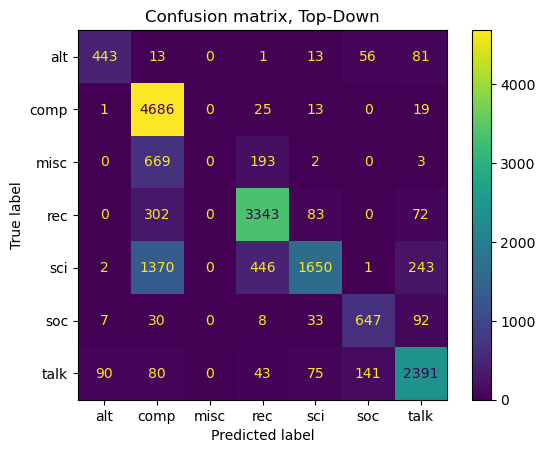

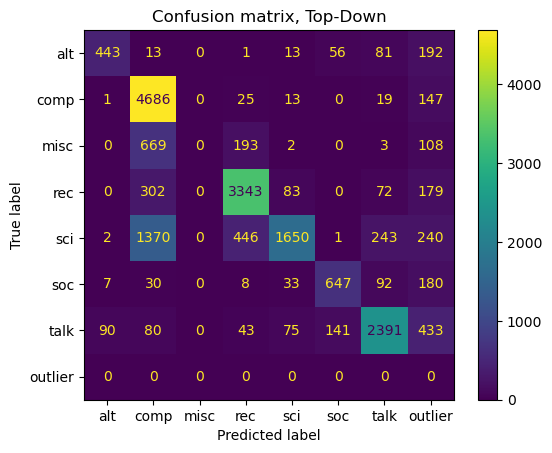

In [18]:
conf_mat = np.zeros((7,7))
y_true = []
y_pred = []
for st in [i for i in res if len(i)>=20]:
    pred = get_dist_memo(memo,st).argmax()
    for leaf in st:
        high_lab, true = leaf_name_to_high_lab(leaf.name)
        conf_mat[true,pred] += 1
        y_true.append(true)
        y_pred.append(pred)
    

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=l_high_lab)
disp.plot(values_format = '.0f')
plt.title("Confusion matrix, Top-Down")
acc = conf_mat.diagonal().sum()/conf_mat.sum()
acc_w_na = conf_mat.diagonal().sum()/len(t)
mcc = matthews_corrcoef(y_true,y_pred)
print(f"{mcc=}")
print(f"{acc_w_na=}")
print(f'accuracy: {accuracy_score(y_true, y_pred)}')
print(classification_report(y_true, y_pred, target_names=l_high_lab))

conf_mat = np.zeros((8,8))
y_true = []
y_pred = []
for st in res:
    pred = get_dist_memo(memo,st).argmax()
    if len(st) < 20:
        pred = 7
    for leaf in st:
        high_lab, true = leaf_name_to_high_lab(leaf.name)
        conf_mat[true,pred] += 1
        y_true.append(true)
        y_pred.append(pred)
    
pred = 7
for leaf in unc:
    high_lab, true = leaf_name_to_high_lab(leaf.name)
    conf_mat[true,pred] += 1
    y_true.append(true)
    y_pred.append(pred)
    
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=l_high_lab+ ["outlier"])
disp.plot(values_format = '.0f')
plt.title("Confusion matrix, Top-Down")
acc = conf_mat.diagonal().sum()/conf_mat.sum()
acc_w_na = conf_mat.diagonal().sum()/len(t)
mcc = matthews_corrcoef(y_true,y_pred)
print(f"{mcc=}")
print(f"{acc_w_na=}")
print(f'accuracy: {accuracy_score(y_true, y_pred)}')
print(classification_report(y_true, y_pred, target_names=l_high_lab+ ["outlier"]))


with open('iTOL/20news/itol_20news_strip_Top-Down_pred_SCUT.txt','w') as f:
    f.write("DATASET_COLORSTRIP\n")
    f.write("SEPARATOR TAB\n")
    f.write("DATASET_LABEL\tnewsgroup_top-down\n")
    f.write("COLOR\t#ff0000\n")
    f.write("LEGEND_TITLE\tNewsgroups_top-down\n")
    f.write("LEGEND_SCALE\t1\n")
    f.write("LEGEND_SHAPES"+"\t1"*len(l_high)+"\n")
    f.write("LEGEND_COLORS\t"+"\t".join(l_col_high)+"\n")
    f.write("LEGEND_LABELS\t"+"\t".join(l_high)+"\n")
    
    f.write("DATA\n")
    
    #for seq_id in seq_ids:
    #    true,_ = seq_id.split("_")
    #    col = l_col_low[int(tgt)]

    #    f.write(seq_id+"\t"+col+"\t"+l_high[int(tgt)]+"\n")
    for st in [i for i in res if len(i)>=20]: #set of selected subtrees with more than 20 leaves
        pred = get_dist_memo(memo,st).argmax()
        label = l_high[pred]
        col = l_col_high[pred]
        for i in st:
            seq_id = i.name
            f.write(seq_id+"\t"+col+"\t"+label+"\n")

In [11]:
t2 = Tree("trees/20newsgroups_Zha.tree",format=1)
memo2 = dict()

mcc=0.436469697977921
acc_w_na=0.5354982489652976
accuracy: 0.5507230559345156
              precision    recall  f1-score   support

         alt       0.00      0.00      0.00       793
        comp       0.52      0.78      0.62      4759
        misc       0.00      0.00      0.00       954
         rec       0.62      0.78      0.69      3877
         sci       0.67      0.33      0.45      3789
         soc       0.00      0.00      0.00       985
        talk       0.48      0.66      0.56      3168

    accuracy                           0.55     18325
   macro avg       0.33      0.36      0.33     18325
weighted avg       0.49      0.55      0.50     18325



/home/pho/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pho/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pho/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


mcc=0.4200288378229429
acc_w_na=0.5354982489652976
accuracy: 0.5354982489652976
              precision    recall  f1-score   support

         alt       0.00      0.00      0.00       799
        comp       0.52      0.76      0.62      4891
        misc       0.00      0.00      0.00       975
         rec       0.62      0.76      0.68      3979
         sci       0.67      0.32      0.43      3952
         soc       0.00      0.00      0.00       997
        talk       0.48      0.64      0.55      3253
     outlier       0.00      0.00      0.00         0

    accuracy                           0.54     18846
   macro avg       0.29      0.31      0.28     18846
weighted avg       0.49      0.54      0.49     18846



/home/pho/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pho/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pho/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pho/anaconda3/lib/python

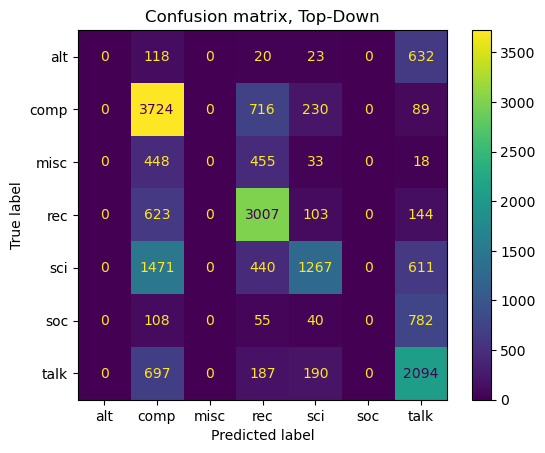

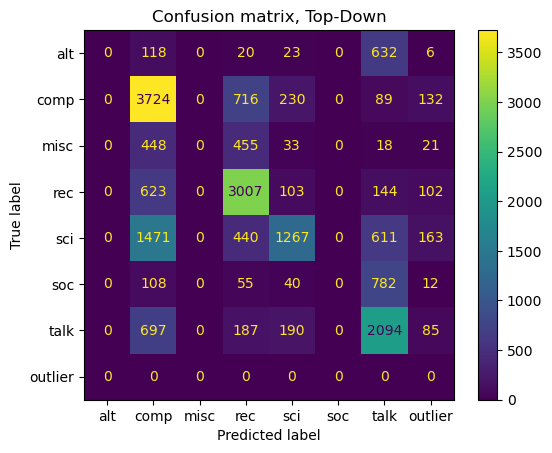

In [21]:
res, unc = split(t2,0.075,memo=memo2)

conf_mat = np.zeros((7,7))
y_true = []
y_pred = []
for st in [i for i in res if len(i)>=20]:
    pred = get_dist_memo(memo2,st).argmax()
    for leaf in st:
        high_lab, true = leaf_name_to_high_lab(leaf.name)
        conf_mat[true,pred] += 1
        y_true.append(true)
        y_pred.append(pred)
    

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=l_high_lab)
disp.plot(values_format = '.0f')
plt.title("Confusion matrix, Top-Down")
acc = conf_mat.diagonal().sum()/conf_mat.sum()
acc_w_na = conf_mat.diagonal().sum()/len(t2)
mcc = matthews_corrcoef(y_true,y_pred)

print(f"{mcc=}")
print(f"{acc_w_na=}")
print(f'accuracy: {accuracy_score(y_true, y_pred)}')
print(classification_report(y_true, y_pred, target_names=l_high_lab))


conf_mat = np.zeros((8,8))
y_true = []
y_pred = []
for st in res:
    pred = get_dist_memo(memo2,st).argmax()
    if len(st) < 20:
        pred = 7
    for leaf in st:
        high_lab, true = leaf_name_to_high_lab(leaf.name)
        conf_mat[true,pred] += 1
        y_true.append(true)
        y_pred.append(pred)
    
pred = 7
for st in unc:
    for leaf in st:
        high_lab, true = leaf_name_to_high_lab(leaf.name)
        conf_mat[true,pred] += 1
        y_true.append(true)
        y_pred.append(pred)
    
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=l_high_lab+ ["outlier"])
disp.plot(values_format = '.0f')
plt.title("Confusion matrix, Top-Down")
acc = conf_mat.diagonal().sum()/conf_mat.sum()
acc_w_na = conf_mat.diagonal().sum()/len(t)
mcc = matthews_corrcoef(y_true,y_pred)
print(f"{mcc=}")
print(f"{acc_w_na=}")
print(f'accuracy: {accuracy_score(y_true, y_pred)}')
print(classification_report(y_true, y_pred, target_names=l_high_lab+ ["outlier"]))


with open('iTOL/20news/itol_20news_strip_Top-Down_pred_Zha.txt','w') as f:
    f.write("DATASET_COLORSTRIP\n")
    f.write("SEPARATOR TAB\n")
    f.write("DATASET_LABEL\tnewsgroup_top-down\n")
    f.write("COLOR\t#ff0000\n")
    f.write("LEGEND_TITLE\tNewsgroups_top-down\n")
    f.write("LEGEND_SCALE\t1\n")
    f.write("LEGEND_SHAPES"+"\t1"*len(l_high)+"\n")
    f.write("LEGEND_COLORS\t"+"\t".join(l_col_high)+"\n")
    f.write("LEGEND_LABELS\t"+"\t".join(l_high)+"\n")
    f.write("DATA\n")
    
    #for seq_id in seq_ids:
    #    true,_ = seq_id.split("_")
    #    col = l_col_low[int(tgt)]

    #    f.write(seq_id+"\t"+col+"\t"+l_high[int(tgt)]+"\n")
    for st in [i for i in res if len(i)>=20]: #set of selected subtrees with more than 20 leaves
        pred = get_dist_memo(memo2,st).argmax()
        label = l_high[pred]
        col = l_col_high[pred]
        for i in st:
            seq_id = i.name
            f.write(seq_id+"\t"+col+"\t"+label+"\n")



In [7]:
t = Tree("trees/20newsgroups_Ward.tree",format=1)
memo = dict()
res, unc = split(t,0.14)
print(len([(i.name,len(i)) for i in res if len(i)>=20]))
print([(i.name,len(i)) for i in res if len(i)>20])
print(len([i.name for i in unc])+sum([len(i) for i in res if len(i)<20]))

57
[('I3', 28), ('I30', 1916), ('I2175', 24), ('I2229', 23), ('I2269', 40), ('I2308', 6916), ('I9225', 1001), ('I10226', 128), ('I10355', 26), ('I10381', 199), ('I10593', 558), ('I11152', 76), ('I11364', 23), ('I11403', 26), ('I11428', 173), ('I11615', 34), ('I11649', 390), ('I12039', 50), ('I12117', 76), ('I12193', 25), ('I12247', 28), ('I12404', 204), ('I12672', 121), ('I12805', 27), ('I12911', 24), ('I13011', 300), ('I13312', 43), ('I13397', 209), ('I13694', 1681), ('I15464', 81), ('I15544', 25), ('I15774', 85), ('I15882', 25), ('I15939', 68), ('I16029', 27), ('I16118', 25), ('I16143', 378), ('I16574', 27), ('I16600', 126), ('I16726', 174), ('I16901', 48), ('I16948', 653), ('I17601', 186), ('I17787', 153), ('I17940', 33), ('I17975', 35), ('I18075', 24), ('I18182', 73), ('I18325', 32), ('I18541', 29), ('I18570', 34), ('I18608', 21), ('I18629', 26), ('I18707', 24), ('I18801', 23)]
2002


mcc=0.5110812614146928
acc_w_na=0.533004351055927
accuracy: 0.5963547850866777
              precision    recall  f1-score   support

         alt       0.95      0.38      0.54       506
        comp       0.47      0.91      0.62      4673
        misc       0.00      0.00      0.00       896
         rec       0.91      0.44      0.59      3726
         sci       0.86      0.42      0.56      3394
         soc       0.67      0.65      0.66       820
        talk       0.60      0.71      0.65      2829

    accuracy                           0.60     16844
   macro avg       0.64      0.50      0.52     16844
weighted avg       0.67      0.60      0.57     16844



/home/pho/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pho/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pho/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


mcc=0.4452366399423992
acc_w_na=0.533004351055927
accuracy: 0.533004351055927
              precision    recall  f1-score   support

         alt       0.95      0.24      0.38       799
        comp       0.47      0.87      0.61      4891
        misc       0.00      0.00      0.00       975
         rec       0.91      0.41      0.57      3979
         sci       0.86      0.36      0.50      3952
         soc       0.67      0.53      0.59       997
        talk       0.60      0.62      0.61      3253
     outlier       0.00      0.00      0.00         0

    accuracy                           0.53     18846
   macro avg       0.56      0.38      0.41     18846
weighted avg       0.67      0.53      0.54     18846



/home/pho/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pho/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pho/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pho/anaconda3/lib/python

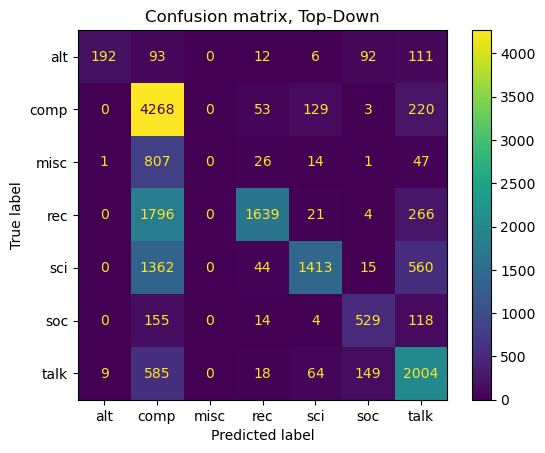

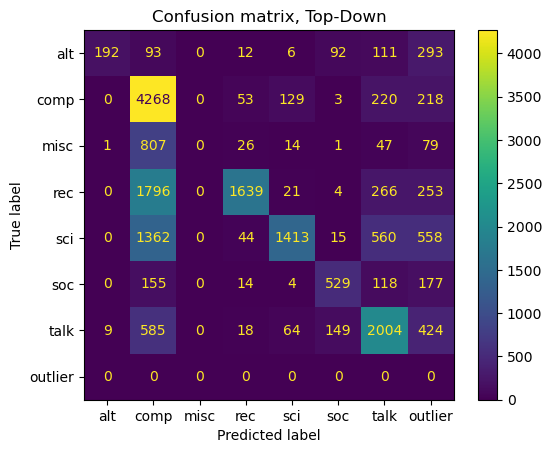

In [8]:
conf_mat = np.zeros((7,7))
y_true = []
y_pred = []
for st in [i for i in res if len(i)>=20]:
    pred = get_dist_memo(memo,st).argmax()
    for leaf in st:
        high_lab, true = leaf_name_to_high_lab(leaf.name)
        conf_mat[true,pred] += 1
        y_true.append(true)
        y_pred.append(pred)
    

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=l_high_lab)
disp.plot(values_format = '.0f')
plt.title("Confusion matrix, Top-Down")
acc = conf_mat.diagonal().sum()/conf_mat.sum()
acc_w_na = conf_mat.diagonal().sum()/len(t)
mcc = matthews_corrcoef(y_true,y_pred)
print(f"{mcc=}")
print(f"{acc_w_na=}")
print(f'accuracy: {accuracy_score(y_true, y_pred)}')
print(classification_report(y_true, y_pred, target_names=l_high_lab))

conf_mat = np.zeros((8,8))
y_true = []
y_pred = []
for st in res:
    pred = get_dist_memo(memo,st).argmax()
    if len(st) < 20:
        pred = 7
    for leaf in st:
        high_lab, true = leaf_name_to_high_lab(leaf.name)
        conf_mat[true,pred] += 1
        y_true.append(true)
        y_pred.append(pred)
    
pred = 7
for leaf in unc:
    high_lab, true = leaf_name_to_high_lab(leaf.name)
    conf_mat[true,pred] += 1
    y_true.append(true)
    y_pred.append(pred)
    
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=l_high_lab+ ["outlier"])
disp.plot(values_format = '.0f')
plt.title("Confusion matrix, Top-Down")
acc = conf_mat.diagonal().sum()/conf_mat.sum()
acc_w_na = conf_mat.diagonal().sum()/len(t)
mcc = matthews_corrcoef(y_true,y_pred)
print(f"{mcc=}")
print(f"{acc_w_na=}")
print(f'accuracy: {accuracy_score(y_true, y_pred)}')
print(classification_report(y_true, y_pred, target_names=l_high_lab+ ["outlier"]))


with open('iTOL/20news/itol_20news_strip_Top-Down_pred_Ward.txt','w') as f:
    f.write("DATASET_COLORSTRIP\n")
    f.write("SEPARATOR TAB\n")
    f.write("DATASET_LABEL\tnewsgroup_top-down\n")
    f.write("COLOR\t#ff0000\n")
    f.write("LEGEND_TITLE\tNewsgroups_top-down\n")
    f.write("LEGEND_SCALE\t1\n")
    f.write("LEGEND_SHAPES"+"\t1"*len(l_high)+"\n")
    f.write("LEGEND_COLORS\t"+"\t".join(l_col_high)+"\n")
    f.write("LEGEND_LABELS\t"+"\t".join(l_high)+"\n")
    
    f.write("DATA\n")
    
    #for seq_id in seq_ids:
    #    true,_ = seq_id.split("_")
    #    col = l_col_low[int(tgt)]

    #    f.write(seq_id+"\t"+col+"\t"+l_high[int(tgt)]+"\n")
    for st in [i for i in res if len(i)>=20]: #set of selected subtrees with more than 20 leaves
        pred = get_dist_memo(memo,st).argmax()
        label = l_high[pred]
        col = l_col_high[pred]
        for i in st:
            seq_id = i.name
            f.write(seq_id+"\t"+col+"\t"+label+"\n")

In [43]:
l_high_lab = []
newsgroups_vectorized = fetch_20newsgroups_vectorized(subset='all',remove=('headers', 'footers', 'quotes'))
for i in newsgroups_vectorized.target_names:
    if i.split(".")[0] not in l_high_lab:
        l_high_lab.append(i.split(".")[0])
l_high_lab

['alt', 'comp', 'misc', 'rec', 'sci', 'soc', 'talk']

In [44]:
def leaf_name_to_high_lab(leaf_name):
    lab = int(leaf_name.split("_")[0])
    lab_name = newsgroups_vectorized.target_names[lab]
    high_lab = lab_name.split(".")[0]
    idx = l_high_lab.index(high_lab)
    return high_lab, idx

In [45]:
def KL(a, b):
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

def get_dist_memo(memo,tree):
    if tree.name not in memo:
        lab_count = np.zeros(7)
        for i in tree.get_leaf_names():
            _, idx = leaf_name_to_high_lab(i)
            lab_count[idx] += 1
        memo[tree.name] = lab_count/lab_count.sum()
    return memo[tree.name]

memo = dict()
def split(tree,th,memo=memo):
    res = []
    unc = []
    todo = [tree]
    
    while todo:
        curr = todo.pop()
        dist_parent = get_dist_memo(memo,curr)
        if len(curr.children) == 2:
            left,right = curr.children
            dist_left, dist_right = get_dist_memo(memo,left),get_dist_memo(memo,right)
            with warnings.catch_warnings(action="ignore"):
                if (KL(dist_left,dist_parent) > th) or (KL(dist_right,dist_parent) > th):
                    todo.append(left)
                    todo.append(right)
                else:
                    res.append(curr)
        else:
            unc.append(curr)
    return res,unc

In [46]:
res, unc = split(t,0.14)
print(len([(i.name,len(i)) for i in res if len(i)>=20]))
print([(i.name,len(i)) for i in res if len(i)>20])
print(len([i.name for i in unc])+sum([len(i) for i in res if len(i)<20]))

57
[('I3', 28), ('I30', 1916), ('I2175', 24), ('I2229', 23), ('I2269', 40), ('I2308', 6916), ('I9225', 1001), ('I10226', 128), ('I10355', 26), ('I10381', 199), ('I10593', 558), ('I11152', 76), ('I11364', 23), ('I11403', 26), ('I11428', 173), ('I11615', 34), ('I11649', 390), ('I12039', 50), ('I12117', 76), ('I12193', 25), ('I12247', 28), ('I12404', 204), ('I12672', 121), ('I12805', 27), ('I12911', 24), ('I13011', 300), ('I13312', 43), ('I13397', 209), ('I13694', 1681), ('I15464', 81), ('I15544', 25), ('I15774', 85), ('I15882', 25), ('I15939', 68), ('I16029', 27), ('I16118', 25), ('I16143', 378), ('I16574', 27), ('I16600', 126), ('I16726', 174), ('I16901', 48), ('I16948', 653), ('I17601', 186), ('I17787', 153), ('I17940', 33), ('I17975', 35), ('I18075', 24), ('I18182', 73), ('I18325', 32), ('I18541', 29), ('I18570', 34), ('I18608', 21), ('I18629', 26), ('I18707', 24), ('I18801', 23)]
2002
